In [2]:
#
import numpy as np
import xarray as xr
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Rectangle
import os
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import cmaps
import matplotlib.ticker as ticker
from PyEMD import EEMD
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.signal import butter, filtfilt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress, boxcox
import seawater
import warnings
import tnflux
from scipy.ndimage import gaussian_filter
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from eofs.standard import Eof
warnings.filterwarnings('ignore')

def add_right_cax_big (ax0, ax7, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x1 + pad, #ax0 的右边 (x1) 加上 pad 的值
        axpos2.y0,
        axpos1.x1 + pad + width,#颜色条的宽度
        axpos1.y1
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_right_cax_big_adj (ax0, ax7, pad, width,k) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x1 + pad, #ax0 的右边 (x1) 加上 pad 的值
        axpos2.y0,
        axpos1.x1 + pad + width,#颜色条的宽度
        axpos1.y0 + k*(axpos1.y1 - axpos1.y0)
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big (ax0, ax7, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x0,
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big_left (ax0, ax7, pad, width, k) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x0,
        axpos1.y0 - pad -width,
        axpos1.x0+k*(axpos2.x1-axpos1.x0),
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax


def add_bottom_cax_big_right (ax0, ax7, pad, width, k) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos2.x1-k*(axpos2.x1-axpos1.x0),
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

plt.rcParams['font.sans-serif']=['Helvetica']


/tmp/ipykernel_14246/426468582.py:28: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [23]:
fig_format = 'pdf'

In [3]:
def ToXr(data,lon,lat):
    res = xr.DataArray(
    data,
    dims=['lat', 'lon'],
    coords={
        'lat': lat, 
        'lon': lon
    }
)
    return res

def wave_flux(hgt0,ucli,vcli,uwnd_ana,vwnd_ana,hgt_ana):
    ##  λ: lamd ; φ: fai ;  Ψ: pasi ; 偏倒：prime
    import metpy.calc as mpcalc
    from metpy.constants import earth_avg_radius
    from metpy.units import units

    def rad(input_data):
        output_data = np.deg2rad(input_data)*units('1')
        return output_data
    
    lon_rad = rad(uwnd_ana.lon) ; lat_rad = rad(uwnd_ana.lat)
    f = mpcalc.coriolis_parameter(hgt_ana.lat)  # 科氏参数
    R = earth_avg_radius 
    p = hgt0*units('hPa'); P0 = 1000*units('hPa')   ### 选取高度层

    ### 传入数据
    Ucli = ucli.assign_coords({'lon':lon_rad, 'lat':lat_rad})*units('m/s') 
    Vcli = vcli.assign_coords({'lon':lon_rad, 'lat':lat_rad})*units('m/s')
    UVcli = mpcalc.wind_speed(Ucli, Vcli)

    fai_g = mpcalc.height_to_geopotential(hgt_ana*units('m'))
    fai = fai_g.assign_coords({'lon':lon_rad, 'lat':lat_rad})
    u = uwnd_ana.assign_coords({'lon':lon_rad, 'lat':lat_rad}) 
    v = vwnd_ana.assign_coords({'lon':lon_rad, 'lat':lat_rad})
    UVcli_rad = UVcli.assign_coords({'lon':lon_rad, 'lat':lat_rad})
    f_rad = f.assign_coords({'lat':lat_rad})
    cos_fai = np.cos(lat_rad).assign_coords({'lat':lat_rad})
    pasi = fai / f_rad

    ## 求取偏导关系
    Dpsi_prime_Dlamd = pasi.differentiate('lon')
    Dpsi_prime_Dfai = pasi.differentiate('lat')
    DDpsi2_prime_DDlamd2 = Dpsi_prime_Dlamd.differentiate('lon')
    DDpsi2_prime_DDfai2 = Dpsi_prime_Dfai.differentiate('lat')
    DDpsi2_prime_DDlamdfai = Dpsi_prime_Dlamd.differentiate('lat')

    ### 将公共项拆分terms
    term_1 = p/P0*cos_fai/(2*abs(UVcli_rad))/(R**2)
    term_2 = Dpsi_prime_Dlamd*Dpsi_prime_Dfai - pasi*DDpsi2_prime_DDlamdfai

    Fx = term_1*(Ucli/cos_fai**2 * (Dpsi_prime_Dlamd**2 - pasi*DDpsi2_prime_DDlamd2) +Vcli/cos_fai*term_2)
    Fy = term_1*(Ucli/cos_fai*term_2 + Vcli*(Dpsi_prime_Dfai**2 - pasi*DDpsi2_prime_DDfai2))

    T_N_flux = Fx.assign_coords({'lon': ucli.lon, 'lat': ucli.lat})
    T_N_fluy = Fy.assign_coords({'lon': vcli.lon, 'lat': vcli.lat})    

    return T_N_flux, T_N_fluy

In [4]:
def is_point_inside_polygon(point, polygon):
    point_obj = Point(point[0], point[1])
    return polygon.contains(point_obj) #不规则图形掩码

def Area_mask(data,lat0,lat1,lon0,lon1,Points):
    mask = data.copy()
    try:
        mask.loc[{'lat':slice(lat0,lat1),'lon':slice(lon0,lon1)}] = np.nan
    except KeyError:
        mask.loc[{'latitude':slice(lat0,lat1),'longitude':slice(lon0,lon1)}] = np.nan
    
    polygon = Polygon(Points)

    it = np.ndindex(np.squeeze(data[0].T).shape)
    for idx in it:
        lon_idx = idx[0]
        lat_idx = idx[1]
        try:
            lon = mask.lon[lon_idx]
            lat = mask.lat[lat_idx]
        except AttributeError:
            lon = mask.longitude[lon_idx]
            lat = mask.latitude[lat_idx]
        point = (lon,lat)
        if is_point_inside_polygon(point, polygon):
            mask[:,lat_idx, lon_idx] = np.nan
    return mask

def weight_mean(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        w = weight.copy()
        w[np.isnan(data[i])] = np.nan
        res[i] = np.nansum(data[i,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def Cal_mon_clim(data,n_start,n_end):
    data_bar = np.nanmean(np.reshape(np.array(data[n_start:n_end]),(30,12,np.shape(data)[1],np.shape(data)[2])),0)
    data_bar = np.tile(data_bar,(50,1,1))[:np.shape(data)[0]]
    data_prime = data - data_bar
    return data_bar, data_prime

# index: 时间序列 (1D), 长度为T
# var: 空间-时间变量 (3D, 形状为 T x lat x lon)

def regress_index_to_field(index, var):
    slope = np.empty(var.shape[1:]) * np.nan
    pval  = np.empty(var.shape[1:]) * np.nan

    for i in range(var.shape[1]):
        for j in range(var.shape[2]):
            y = var[:, i, j]
            if np.all(np.isnan(y)):
                continue
            slope[i, j], _, _, pval[i, j], _ = stats.linregress(index, y)
    return slope, pval

def sel_year(data,m1,m2):
    res = np.zeros((round(np.shape(data)[0]/12),np.shape(data)[1],np.shape(data)[2]))
    for i in range(round(np.shape(data)[0]/12)):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2],0)
    return res

def sel_year_1d(data,m1,m2):
    res = np.zeros(round(len(data)/12))
    for i in range(round(len(data)/12)):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2])
    return res

def tscale_filter(data):
    long = gaussian_filter(data,192/1.414) #32years
    multidecade = gaussian_filter(data-long,48/1.414) #8-32years
    interan = gaussian_filter(data-long-multidecade,12/1.414)  #2years
    res = data - (long + multidecade + interan)
    return res

def norm(data):
    res = (data-np.mean(data))/np.std(data,ddof=1)
    return res

In [5]:
def OISST_series():
    fpath = '/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['sst']
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_E1 = [(130.5, 34),(130.2, 35),(129.5, 35.5),(131.5, 35.5),(131.5, 34)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = sst.sel(lon=slice(104, 131.5),lat=slice(0,42)).squeeze()
    sst_ES = Area_mask(sst_ES,35.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_E1)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    sst_EP = sst.sel(lon=slice(270, 280),lat=slice(-10,0)).resample(time='ME').mean().squeeze()
    sst_NAT = sst.sel(lon=slice(300, 340),lat=slice(0,50)).resample(time='ME').mean().squeeze()
    return sst_ES, mask_ES, sst_NAT, sst_EP

In [6]:
print('Open TNFLUX')
TNFLUX1 = xr.open_dataset('./ERA5/TNFLUX_200_1.nc')
TNFLUX1 = TNFLUX1.reindex(latitude=list(reversed(TNFLUX1.latitude))).sel(latitude=slice(-10,80)).squeeze()        
print('Open TNFLUX')
TNFLUX2 = xr.open_dataset('./ERA5/TNFLUX_200.nc')
TNFLUX2 = TNFLUX2.reindex(latitude=list(reversed(TNFLUX2.latitude))).sel(latitude=slice(-10,80)).squeeze() 
print('Open PHight')
GP = xr.open_dataset('./ERA5/press_high.nc')
GP = GP.reindex(latitude=list(reversed(GP.latitude))).sel(latitude=slice(-10,80)).squeeze()            
print('Open temp')
Temp = xr.open_dataset('./ERA5/Temp.nc')
Temp = Temp.reindex(latitude=list(reversed(Temp.latitude))).sel(latitude=slice(-10,80)).squeeze()
print('Open rain')
Rain = xr.open_dataset('./ERA5/rain_flux.nc')
Rain = Rain.reindex(latitude=list(reversed(Rain.latitude))).sel(latitude=slice(-10,80)).squeeze()

rain = Rain.tp[12:].data
temp = Temp.t2m[12:].data
P = GP.z[12:].data
U200 = np.concatenate([TNFLUX1.u.data, TNFLUX2.u.data],0)
V200 = np.concatenate([TNFLUX1.v.data, TNFLUX2.v.data],0)
P200 = np.concatenate([TNFLUX1.z.data, TNFLUX2.z.data],0)

Open TNFLUX
Open TNFLUX
Open PHight
Open temp
Open rain


In [7]:
lon = GP.longitude.data
lat = GP.latitude.data
Lon_atm, Lat_atm = np.meshgrid(lon, lat)
dx_atm = 6371*1e3*np.pi/180*np.gradient(Lon_atm,axis=1)*np.cos(np.radians(Lat_atm))
dy_atm = 6371*1e3*np.pi/180*np.gradient(Lat_atm,axis=0)

U200_bar, _ = Cal_mon_clim(U200,120-12,480-12)
V200_bar, _ = Cal_mon_clim(V200,120-12,480-12)
P200_bar, P200_prime = Cal_mon_clim(P200,120-12,480-12)

# P200_bar, P200_prime = Cal_mon_clim(P[:,-1,:,:],120-12,480-12)
P500_bar, P500_prime = Cal_mon_clim(P[:,-2,:,:],120-12,480-12)
T_bar, T_prime = Cal_mon_clim(temp,120-12,480-12)
R_bar, R_prime = Cal_mon_clim(rain,120-12,480-12)

In [8]:
f=np.array(2*7.292e-5*np.sin(lat*np.pi/180.0)).reshape((-1,1))
streamf = P200_prime/f

px = np.full_like(sel_year(U200_bar,8,9),np.nan)
py = np.full_like(sel_year(U200_bar,8,9),np.nan)
for i in range(43):
    px[i], py[i] = tnflux.tnf2d(sel_year(U200_bar,8,9)[i], sel_year(V200_bar,8,9)[i], sel_year(P200_bar,8,9)[i], sel_year(P200,8,9)[i], lat, lon, 200) 
mask_small = np.full_like(sel_year(U200_bar,8,9),1)
mask_small[sel_year(U200_bar,8,9)<=0] = np.nan
mask_small[(px**2+py**2)<=9] = np.nan
pxo = px.copy()
pyo = py.copy()
pxo[np.isnan(mask_small)] = np.nan
pyo[np.isnan(mask_small)] = np.nan

In [9]:
sst_ES, mask_ES, sst_NAT, sst_EP = OISST_series()

sst_ES_89 = sst_ES.sel(time=((sst_ES["time.month"] == 8) | (sst_ES["time.month"] == 9)))
base_ES_89 = np.mean(sst_ES_89.sel(time=((sst_ES_89["time.year"] < 2021) & (sst_ES_89["time.year"] > 1990))),0)
std_ES_89 = np.std(sst_ES_89.sel(time=((sst_ES_89["time.year"] < 2021) & (sst_ES_89["time.year"] > 1990))).groupby("time.year").mean(dim="time"),0)
year_ES_89 = sst_ES_89.resample(time='YE').mean()

mask_hightemp = np.full_like(year_ES_89[0],np.nan)
mask_hightemp[(np.mean(sst_ES_89[-61:],0)-base_ES_89)/std_ES_89>3] = 1
mask_hightemp[np.isnan(mask_ES)] = np.nan

Lon, Lat = np.meshgrid(sst_ES.lon, sst_ES.lat)
dx = 6371*1e3*np.pi/180*np.gradient(Lon,axis=1)*np.cos(np.radians(Lat))
dy = 6371*1e3*np.pi/180*np.gradient(Lat,axis=0)

sst_ES_mon = sst_ES.resample(time='ME').mean()
sst_ES_b, sst_ES_p = Cal_mon_clim(sst_ES_mon,9*12,39*12)
sst_EP_b, sst_EP_p = Cal_mon_clim(sst_EP,9*12,39*12)
sst_NAT_b, sst_NAT_p = Cal_mon_clim(sst_NAT,9*12,39*12)
sst_ES_p_ts = weight_mean(sst_ES_p/np.std(sst_ES_p,0)*mask_hightemp,dx,dy)
sst_EP_p_ts = weight_mean(sst_EP_p,np.cos(np.radians(np.meshgrid(sst_EP_p.lon, sst_EP_p.lat)[1])),np.ones_like(sst_EP_p[0]))
sst_NAT_p_ts = weight_mean(sst_NAT_p/np.std(sst_NAT_p,0),np.cos(np.radians(np.meshgrid(sst_NAT_p.lon, sst_NAT_p.lat)[1])),np.ones_like(sst_NAT_p[0]))
# sst_ES_season = sel_year_1d(tscale_filter(sst_ES_p_ts),8,9)
# sst_EP_season = sel_year_1d(tscale_filter(sst_EP_p_ts),8,9)
# sst_NAT_season = sel_year_1d(tscale_filter(sst_NAT_p_ts),8,9)
# sst_IND_season = sel_year_1d(tscale_filter(weight_mean(sst_IND_p,axis=(-2,-1))),8,9)

rain_89 = sel_year(rain,8,9)

In [10]:
sst_ocn = xr.open_dataset('/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc')['sst']
sst_ocn = sst_ocn.resample(time='ME').mean().squeeze().interp(lon=lon,lat=lat)
sst_ocn[:,200:240,1050:1144] = np.nan
sst_ocn[:,:,0] = (sst_ocn[:,:,1] + sst_ocn[:,:,-1])/2
sst_ocn_89 = sel_year(sst_ocn,8,9)

In [11]:
sst_index =  norm(sel_year_1d(sst_NAT_p_ts,8,9))
sst_ep_index =  norm(sel_year_1d(sst_EP_p_ts,8,9))
rain_index = norm(weight_mean(sel_year(rain[:,80:-200,:140],8,9)/np.std(sel_year(rain[:,80:-200,:140],8,9),0),dx_atm[80:-200,:140],dy_atm[80:-200,:140]))
eu_index = norm(Eof(sel_year(np.concatenate([P200_prime[:,120:-40,1200:],P200_prime[:,120:-40,:700]],-1),8,9),weights=dx_atm[120:-40,:940]).pcs()[:,0])
# eu_index = (weight_mean(sel_year(P300_prime,8,9)[:,50:-150,400:550],dx_atm[50:-150,400:550],dy_atm[50:-150,400:550])+
#             weight_mean(sel_year(P300_prime,8,9)[:,170:-20,120:300],dx_atm[170:-20,120:300],dy_atm[170:-20,120:300])-
#             weight_mean(sel_year(P300_prime,8,9)[:,180:-30,1350:],dx_atm[180:-30,1350:],dy_atm[180:-30,1350:])-
#             weight_mean(sel_year(P300_prime,8,9)[:,100:-100,250:350],dx_atm[100:-100,250:350],dy_atm[100:-100,250:350]))

In [12]:
slope_sst, pval_sst = regress_index_to_field(eu_index, sel_year(sst_ocn,8,9)/np.std(sel_year(sst_ocn,8,9)[9:39],0))
mask_p_sst = np.ones_like(pval_sst)
mask_p_sst[pval_sst>0.05] = np.nan
mask_p_sst[np.isnan(pval_sst)] = np.nan
slope_rain, pval_rain = regress_index_to_field(eu_index, sel_year(rain,8,9)/np.std(sel_year(rain,8,9),0))
mask_p_rain = np.ones_like(pval_rain)
mask_p_rain[pval_rain>0.05] = np.nan
mask_p_rain[~np.isnan(pval_sst)] = np.nan

In [13]:
slope, pval = regress_index_to_field(sst_index, sel_year(P200_prime,8,9))
mask_p = np.ones_like(pval)
mask_p[pval>0.05] = np.nan

slope_r, pval_r = regress_index_to_field(rain_index, sel_year(P200_prime,8,9))
mask_p_r = np.ones_like(pval_r)
mask_p_r[pval_r>0.05] = np.nan

# slope_i, pval_i = regress_index_to_field(norm(rain_index+sst_index), sel_year(streamf,8,9))
# mask_p_i = np.ones_like(pval_i)
# mask_p_i[pval_i>0.05] = np.nan

In [14]:
px_r, py_r = tnflux.tnf2d(sel_year(U200_bar,8,9)[-1], sel_year(V200_bar,8,9)[-1], sel_year(P200_bar,8,9)[-1], 
        sel_year(P200_bar,8,9)[-1]+regress_index_to_field(rain_index, sel_year(P200_prime,8,9))[0], lat, lon, 200) 

px_t, py_t = tnflux.tnf2d(sel_year(U200_bar,8,9)[-1], sel_year(V200_bar,8,9)[-1], sel_year(P200_bar,8,9)[-1], 
        sel_year(P200_bar,8,9)[-1]+regress_index_to_field(sst_index, sel_year(P200_prime,8,9))[0], lat, lon, 200) 

In [15]:
mask_small_r = np.full_like(U200_bar[0],1)
mask_small_r[sel_year(U200_bar,8,9)[-1]<=0] = np.nan
mask_small_r[(px_r**2+py_r**2)<=1e-2] = np.nan
pxo_r = px_r.copy()
pyo_r = py_r.copy()
pxo_r[np.isnan(mask_small_r)] = np.nan
pyo_r[np.isnan(mask_small_r)] = np.nan

mask_small_t = np.full_like(U200_bar[0],1)
mask_small_t[sel_year(U200_bar,8,9)[0]<=0] = np.nan
mask_small_t[(px_t**2+py_t**2)<=1e-2] = np.nan
pxo_t = px_t.copy()
pyo_t = py_t.copy()
pxo_t[np.isnan(mask_small_t)] = np.nan
pyo_t[np.isnan(mask_small_t)] = np.nan

In [19]:
# Latent Heat Release Index.
g = 9.81                 # m s-2
Lv = 2.5e6               # J kg-1 (latent heat of vaporization)
Cpw = 1846.1             # J kg-1 K-1 (cp of water vapor ~273 K)
Cw  = 4218.0             # J kg-1 K-1 (cp of liquid water)
path = "/2024data2/yangsl/Yangsl/ERA5/LHRI.nc"
var_u = "u"      # m s-1
var_v = "v"      # m s-1
var_q = "q"      # kg kg-1
var_t = "t"      # K
lev_name = "pressure_level"     # hPa
lat_name = "latitude"
lon_name = "longitude"
REGION = dict(lat_min=10, lat_max=30, lon_min=0, lon_max=35)

def cal_LHI(g, Lv, Cpw, Cw, path, var_u, var_v, var_q, var_t, REGION, lev_name, lat_name, lon_name):
    print("Loading pressure-level data (u,v,q,t)...")
    ds = xr.open_dataset(path)
    if all(REGION.get(k) is not None for k in ["lat_min","lat_max","lon_min","lon_max"]):
        # ERA5 latitude is usually descending; slice handles both orders
        ds = ds.sel(
            **{lat_name: slice(REGION["lat_max"], REGION["lat_min"])},
            **{lon_name: slice(REGION["lon_min"], REGION["lon_max"])},
        )
    ds = ds.resample(valid_time='YE').mean()
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    u = ds[var_u]
    v = ds[var_v]
    q = ds[var_q]
    T = ds[var_t]
    lev = ds[lev_name]   # hPa
    lat = ds[lat_name]
    lon = ds[lon_name]

    A = Lv + (Cpw - Cw) * T
    Fx = u * q * A
    Fy = v * q * A

    dlat_deg = float(np.abs(lat.diff(lat_name)).mean())
    dlon_deg = float(np.abs(lon.diff(lon_name)).mean())
    lat0 = float(lat.mean())  # mean latitude for metric
    deg2m = 111_000.0
    dy = dlat_deg * deg2m
    dx = dlon_deg * deg2m * np.cos(np.deg2rad(lat))

    dFx_dx = xr.apply_ufunc(
        np.gradient, Fx, dx,
        input_core_dims=[[lon_name], []],
        output_core_dims=[[lon_name]],
        exclude_dims=set([lon_name]),
        vectorize=True, dask="parallelized")
    dFy_dy = xr.apply_ufunc(
        np.gradient, Fy, dy,
        input_core_dims=[[lat_name], []],
        output_core_dims=[[lat_name]],
        exclude_dims=set([lat_name]),
        vectorize=True, dask="parallelized")

    div_h = dFx_dx + dFy_dy   # W m-2
    print("Integrating vertically from 1000 to 100 hPa...")
    lev_pa = (ds[lev_name] * 100.0)  # hPa -> Pa
    # div_sel = div_h.where(mask, drop=True)
    # lev_sel = lev_pa.where(mask, drop=True)
    LHI_Wm2 = xr.apply_ufunc(
        np.trapz, div_h, lev_pa,
        input_core_dims=[[lev_name], [lev_name]],
        output_core_dims=[[]],
        vectorize=True, dask="parallelized"
    ) / g

    LHI_Wm2 = LHI_Wm2.rename("LHI_Wm2")
    lat = LHI_Wm2[lat_name]
    lon = LHI_Wm2[lon_name]
    weights = np.cos(np.deg2rad(lat))
    weights = xr.DataArray(weights, coords={lat_name: lat}, dims=(lat_name,))

    LHI_regmean = LHI_Wm2.weighted(weights).mean(dim=[lat_name, lon_name])
    LHI_regmean = LHI_regmean.data
    return LHI_regmean

LHI_regmean = cal_LHI(g, Lv, Cpw, Cw, path, var_u, var_v, var_q, var_t, REGION, lev_name, lat_name, lon_name)

Loading pressure-level data (u,v,q,t)...
Integrating vertically from 1000 to 100 hPa...


In [47]:
pearsonr(eu_index,sel_year_1d(sst_ES_p_ts,8,9))

PearsonRResult(statistic=0.7681323283887572, pvalue=1.8288327075458644e-09)

In [41]:
pearsonr(rain_index+sst_index,sel_year_1d(sst_ES_p_ts,8,9))

PearsonRResult(statistic=0.7411846446507264, pvalue=1.3141623108902804e-08)

In [55]:
pearsonr(rain_index,sel_year_1d(sst_ES_p_ts,8,9))

PearsonRResult(statistic=0.48834310771401834, pvalue=0.0008928002565553914)

In [49]:
pearsonr(rain_index,sst_index)

PearsonRResult(statistic=0.33344340109218173, pvalue=0.028884247575061212)

In [20]:
lon_plot = np.concatenate([lon[721:],lon[:721]])
lon_plot = np.where(lon_plot > 180, lon_plot - 360, lon_plot)

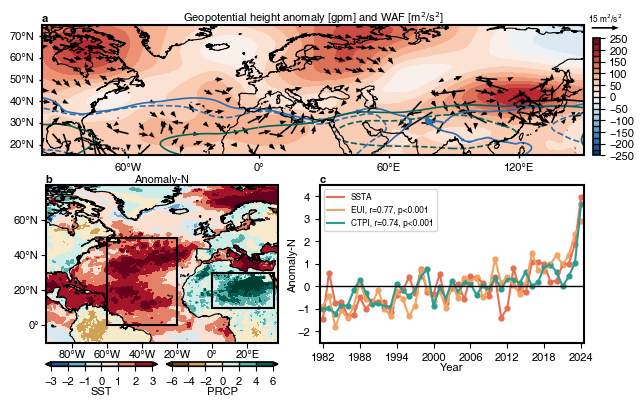

In [42]:
fig = plt.figure(figsize=(7, 4.3))
fig.subplots_adjust(wspace=0.15,hspace=0.1)
gs = GridSpec(2, 2 , figure=fig, width_ratios=[1, 1.1], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax0.set_extent([-100,150,15,75], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs0 = ax0.contourf(lon_plot,lat,np.concatenate([(sel_year(P200_prime,8,9)[-1]/9.8)[:,721:],(sel_year(P200_prime,8,9)[-1]/9.8)[:,:721]],axis=1),cmap='RdBu_r',levels=np.linspace(-250,250,21))
q = ax0.quiver(lon[::20],lat[100::20],pxo[-1,100::20,::20],pyo[-1,100::20,::20],scale=300,width=0.003,headaxislength=4,headlength=4)
ax0.quiverkey(q,1.0388,0.98,U=15,label='15 m$^2$/s$^2$',labelpos='N',labelsep=0.03,fontproperties={'size':6})

ax0.contour(lon,lat,np.mean(P[-5:-3,-2],0)/9.8,levels=[5880],colors=[(42/255,113/255,178/255)],linewidths=1.2)
ax0.contour(lon,lat,np.mean(P500_bar[-5:-3],0)/9.8,levels=[5880],colors=[(42/255,113/255,178/255)],linewidths=1.2,linestyles='--')
ax0.contour(lon,lat,np.mean(P[-5:-3,-1],0)/9.8,levels=[12500],colors=[(1/255,101/255, 91/255)],linewidths=1.2)
ax0.contour(lon,lat,np.mean(P200_bar[-5:-3],0)/9.8,levels=[12500],colors=[(1/255,101/255, 91/255)],linewidths=1.2,linestyles='--')
ax0.spines['geo'].set_linewidth(1.5)
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl0.left_labels = True
gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 8}
gl0.ylabel_style = {'size': 8}
ax0.set_xticks([-60, 0, 60, 120])
ax0.set_xticklabels([' ',' ',' ',' '])
ax0.set_yticks([20, 30, 40, 50, 60, 70])
ax0.set_yticklabels([' ',' ',' ',' ',' ',' '])
gl0.xlocator = ticker.FixedLocator([-60, 0, 60, 120])
gl0.ylocator = ticker.FixedLocator([20, 30,40, 50, 60, 70])
ax0.tick_params(axis='both', length=2, width=1)

ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([-95,37.5,-10,80], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs3 = ax2.contourf(lon_plot,lat,np.concatenate([((rain_89[-1]-np.mean(rain_89[9:39],0))/np.std(rain_89,0))[:,721:],
                ((rain_89[-1]-np.mean(rain_89[9:39],0))/np.std(rain_89,0))[:,:721]],axis=1),levels=np.linspace(-6,6,7),cmap='BrBG',extend='both')
cs2 = ax2.contourf(lon_plot,lat,np.concatenate([((sst_ocn_89[-1]-np.mean(sst_ocn_89[9:39],0))/np.std(sst_ocn_89[9:39],0))[:,721:],
                ((sst_ocn_89[-1]-np.mean(sst_ocn_89[9:39],0))/np.std(sst_ocn_89[9:39],0))[:,:721]],axis=1),levels=np.linspace(-3,3,7),cmap='RdBu_r',extend='both')
rect1 = Rectangle((-60, 0), 40, 50, linewidth=1.5, edgecolor='k', facecolor='none')
rect2 = Rectangle((0, 10), 35, 20, linewidth=1.5, edgecolor='k', facecolor='none')             
ax2.add_patch(rect1)
ax2.add_patch(rect2)
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([-80,-60,-40,-20,0,20])
ax2.set_xticklabels([' ',' ',' ',' ',' ',' '])
ax2.set_yticks([0,20, 40, 60])
ax2.set_yticklabels([' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([-80,-60,-40,-20,0,20])
gl2.ylocator = ticker.FixedLocator([0,20, 40, 60])
ax2.spines['geo'].set_linewidth(1.5)

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(np.arange(1982,2025), norm(sel_year_1d(sst_ES_p_ts,8,9)),label='SSTA',c='#E76F51',lw=1.5)
ax3.plot(np.arange(1982,2025), eu_index,label='EUI, r=%.2f, p<0.001'%(pearsonr(eu_index,sel_year_1d(sst_ES_p_ts,8,9))[0]),c='#F4A261',lw=1.5)
ax3.plot(np.arange(1982,2025), (rain_index+sst_index)/2,
        label='CTPI, r=%.2f, p<0.001'%(pearsonr(rain_index+sst_index,sel_year_1d(sst_ES_p_ts,8,9))[0]),c='#2A9D8F',lw=1.5)
ax3.plot(np.arange(1981,2026), np.zeros_like(np.arange(1981,2026)),c='k',lw=1)
ax3.scatter(np.arange(1982,2025), norm(sel_year_1d(sst_ES_p_ts,8,9)),s=12,c='#E76F51')
ax3.scatter(np.arange(1982,2025), eu_index,s=12,c='#F4A261')
ax3.scatter(np.arange(1982,2025), (rain_index+sst_index)/2,s=12,c='#2A9D8F')
ax3.set_xlim([1981.5,2024.5])
ax3.set_ylim([-2.5,4.5])
ax3.set_yticks([-2,-1,0,1,2,3,4],['−2','−1','0','1','2','3','4'],fontsize=8)
ax3.set_xticks([1982,1988,1994,2000,2006,2012,2018,2024],[1982,1988,1994,2000,2006,2012,2018,2024],fontsize=8)
ax3.set_xlabel('Year',fontsize=8,labelpad=0)
ax3.set_ylabel("Anomaly-N",fontsize=8,labelpad=0)
ax3.legend(loc='upper left',ncol=1,fontsize=6)
ax3.spines[['top','bottom','left','right']].set_linewidth(1.5)
# ax3.grid()

cax = add_right_cax_big_adj(ax0,ax0, pad=0.012, width=0.01,k=0.9)
cb =  fig.colorbar(cs0,cax=cax,drawedges=True)
cb.set_ticks([-250,-200,-150,-100,-50,0,50,100,150,200,250])
cb.set_ticklabels(['−250','−200','−150','−100','−50','0','50','100','150','200','250'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

cax = add_bottom_cax_big_left(ax2,ax2, pad=0.045, width=0.01, k=0.48)
cb =  fig.colorbar(cs2,cax=cax,drawedges=True,orientation='horizontal')
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('SST',fontsize=8,labelpad=0)

cax = add_bottom_cax_big_right(ax2,ax2, pad=0.045, width=0.01, k=0.48)
cb =  fig.colorbar(cs3,cax=cax,drawedges=True,orientation='horizontal')
cb.set_ticks([-6,-4,-2,0,2,4,6])
cb.set_ticklabels(['−6','−4','−2','0','2','4','6'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('PRCP',fontsize=8,labelpad=0)

ax0.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
# ax1.set_title('(b)',fontsize=15,loc='left')
ax2.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax3.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax0.set_title('Geopotential height anomaly [gpm] and WAF [m$^2$/s$^2$]',fontsize=8,pad=2)
# ax1.set_title('SF Anomaly [10$^6$ m$^2$/s] and WAF [m$^2$/s$^2$]',fontsize=15)
ax2.set_title('Anomaly-N',fontsize=8,pad=2)
# ax0.set_title('Aug-Sep',fontsize=8,loc='right',pad=2)
# ax2.set_title('Aug-Sep',fontsize=8,loc='right',pad=2)

fig_format = 'pdf'
fig.savefig('./fig/Fig5.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

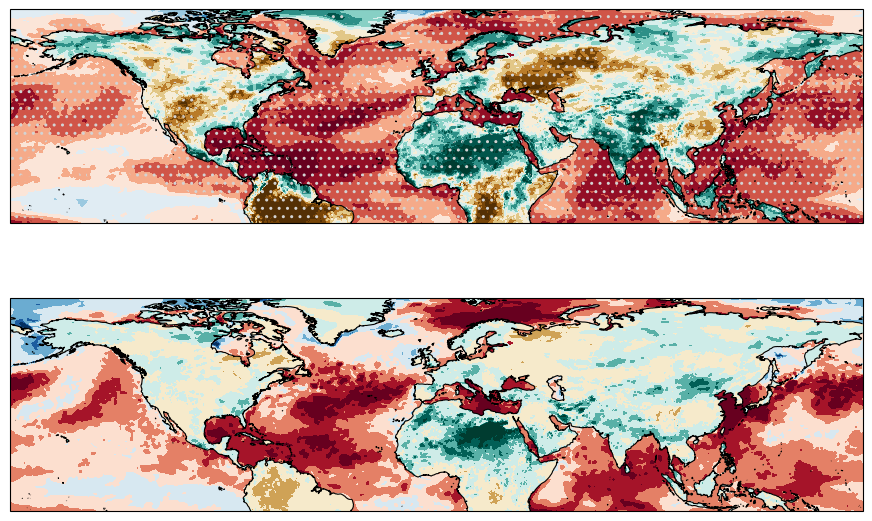

In [21]:
fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.15,wspace=0.11)
gs = GridSpec(2, 1 , figure=fig)

ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
# ax2.set_extent([-95,37.5,-10,80], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs3 = ax2.contourf(lon_plot,lat,np.concatenate([slope_rain[:,721:],slope_rain[:,:721]],axis=1),levels=np.linspace(-0.5,0.5,9),cmap='BrBG',extend='both')
cs2 = ax2.contourf(lon_plot,lat,np.concatenate([slope_sst[:,721:],slope_sst[:,:721]],axis=1),levels=np.linspace(-1,1,9),cmap='RdBu_r',extend='both')
d1 = ax2.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_sst,colors='none',hatches=['..'])
d2 = ax2.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_rain,colors='none',hatches=['..'])
for collection in d1.collections:
    collection.set_edgecolor('lightgrey')
for collection in d1.collections:
    collection.set_linewidth(0)
for collection in d2.collections:
    collection.set_edgecolor('lightgrey')
for collection in d2.collections:
    collection.set_linewidth(0)

ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=0))
# ax2.set_extent([-95,37.5,-10,80], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs3 = ax2.contourf(lon_plot,lat,np.concatenate([((rain_89[-1]-np.mean(rain_89[9:39],0))/np.std(rain_89,0))[:,721:],
                ((rain_89[-1]-np.mean(rain_89[9:39],0))/np.std(rain_89,0))[:,:721]],axis=1),levels=np.linspace(-6,6,7),cmap='BrBG',extend='both')
cs2 = ax2.contourf(lon_plot,lat,np.concatenate([((sst_ocn_89[-1]-np.mean(sst_ocn_89[9:39],0))/np.std(sst_ocn_89[9:39],0))[:,721:],
                ((sst_ocn_89[-1]-np.mean(sst_ocn_89[9:39],0))/np.std(sst_ocn_89[9:39],0))[:,:721]],axis=1),levels=np.linspace(-3,3,7),cmap='RdBu_r',extend='both')

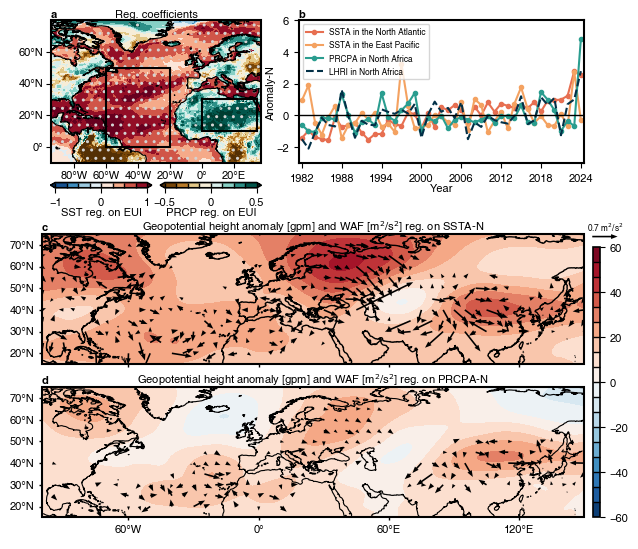

In [24]:
fig = plt.figure(figsize=(7, 6.5))
fig.subplots_adjust(hspace=0.15,wspace=0.11)
gs = GridSpec(4, 2 , figure=fig, height_ratios=[1.05, 0.25, 1, 1], width_ratios=[0.8,1])

ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([-95,37.5,-10,80], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs3 = ax2.contourf(lon_plot,lat,np.concatenate([slope_rain[:,721:],slope_rain[:,:721]],axis=1),levels=np.linspace(-0.5,0.5,9),cmap='BrBG',extend='both')
cs2 = ax2.contourf(lon_plot,lat,np.concatenate([slope_sst[:,721:],slope_sst[:,:721]],axis=1),levels=np.linspace(-1,1,9),cmap='RdBu_r',extend='both')
d1 = ax2.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_sst,colors='none',hatches=['..'])
d2 = ax2.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_rain,colors='none',hatches=['..'])
for collection in d1.collections:
    collection.set_edgecolor('lightgrey')
for collection in d1.collections:
    collection.set_linewidth(0)
for collection in d2.collections:
    collection.set_edgecolor('lightgrey')
for collection in d2.collections:
    collection.set_linewidth(0)
rect1 = Rectangle((-60, 0), 40, 50, linewidth=1.5, edgecolor='k', facecolor='none')
rect2 = Rectangle((0, 10), 35, 20, linewidth=1.5, edgecolor='k', facecolor='none')             
ax2.add_patch(rect1)
ax2.add_patch(rect2)
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([-80,-60,-40,-20,0,20])
ax2.set_xticklabels([' ',' ',' ',' ',' ',' '])
ax2.set_yticks([0,20, 40, 60])
ax2.set_yticklabels([' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([-80,-60,-40,-20,0,20])
gl2.ylocator = ticker.FixedLocator([0,20, 40, 60])
ax2.spines['geo'].set_linewidth(1.5)

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(np.arange(1982,2025), sst_index,label='SSTA in the North Atlantic',c='#E76F51',lw=1.5,marker='o',markersize=3)
ax3.plot(np.arange(1982,2025), sst_ep_index,label='SSTA in the East Pacific',c='#F4A261',lw=1.5,marker='o',markersize=3)
ax3.plot(np.arange(1982,2025), rain_index,label='PRCPA in North Africa',c='#2A9D8F',lw=1.5,marker='o',markersize=3)
ax3.plot(np.arange(1982,2025), norm(LHI_regmean)[:-1],label='LHRI in North Africa',c=(2/255, 48/255, 71/255),ls='--',lw=1.5)
ax3.plot(np.arange(1981,2026), np.zeros_like(np.arange(1981,2026)),c='k',lw=1)
ax3.set_xlim([1981.5,2024.5])
ax3.set_ylim([-3,6])
ax3.set_yticks([-2,0,2,4,6],['−2','0','2','4','6'],fontsize=8)
ax3.set_xticks([1982,1988,1994,2000,2006,2012,2018,2024],[1982,1988,1994,2000,2006,2012,2018,2024],fontsize=8)
ax3.set_xlabel('Year',fontsize=8,labelpad=0)
ax3.set_ylabel("Anomaly-N",fontsize=8,labelpad=0)
ax3.legend(loc='upper left',ncol=1,fontsize=6)
ax3.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax0 = fig.add_subplot(gs[2, :], projection=ccrs.PlateCarree(central_longitude=0))
ax0.set_extent([-100,150,15,75], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1,zorder=4)
cs0 = ax0.contourf(lon_plot,lat,np.concatenate([slope[:,721:],slope[:,:721]],axis=1)/9.8,cmap='RdBu_r',levels=np.linspace(-60,60,19))
# ax0.contourf(sst_ocn.lon,sst_ocn.lat,mask_p,colors='none',hatches=['..'])
q0 = ax0.quiver(lon[::20],lat[120::20],pxo_t[120::20,::20],pyo_t[120::20,::20],scale=15,width=0.003,headaxislength=4,headlength=4)
ax0.quiverkey(q0,1.0382,0.98,U=0.7,label='0.7 m$^2$/s$^2$',labelpos='N',labelsep=0.03,fontproperties={'size':6})
ax0.spines['geo'].set_linewidth(1.5)
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl0.left_labels = True
# gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 8}
gl0.ylabel_style = {'size': 8}
ax0.set_xticks([-60, 0, 60, 120])
ax0.set_xticklabels([' ',' ',' ',' '])
ax0.set_yticks([20, 30, 40, 50, 60, 70])
ax0.set_yticklabels([' ',' ',' ',' ',' ',' '])
gl0.xlocator = ticker.FixedLocator([-60, 0, 60, 120])
gl0.ylocator = ticker.FixedLocator([20, 30,40, 50, 60, 70])
ax0.tick_params(axis='both', length=2, width=1)


ax1 = fig.add_subplot(gs[3, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([-100,150,15,75], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs1 = ax1.contourf(lon_plot,lat,np.concatenate([slope_r[:,721:],slope_r[:,:721]],axis=1)/9.8,cmap='RdBu_r',levels=np.linspace(-60,60,19))
# ax1.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_r,colors='none',hatches=['..'])
q = ax1.quiver(lon[::20],lat[120::20],pxo_r[120::20,::20],pyo_r[120::20,::20],scale=15,width=0.003,headaxislength=4,headlength=4)
ax1.spines['geo'].set_linewidth(1.5)
gl1 =ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl1.left_labels = True
gl1.bottom_labels = True
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}
ax1.set_xticks([-60, 0, 60, 120])
ax1.set_xticklabels([' ',' ',' ',' '])
ax1.set_yticks([20, 30, 40, 50, 60, 70])
ax1.set_yticklabels([' ',' ',' ',' ',' ',' '])
gl1.xlocator = ticker.FixedLocator([-60, 0, 60, 120])
gl1.ylocator = ticker.FixedLocator([20, 30,40, 50, 60, 70])
ax1.tick_params(axis='both', length=2, width=1)

# ax2 = fig.add_subplot(gs[2, :], projection=ccrs.PlateCarree(central_longitude=0))
# ax2.set_extent([-100,150,15,75], crs=ccrs.PlateCarree())
# ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1,zorder=4)
# cs2 = ax2.contourf(lon,lat,slope_i/1e6,cmap='RdBu_r',levels=np.linspace(-6,6,19))
# ax2.contourf(sst_ocn.lon,sst_ocn.lat,mask_p_i,colors='none',hatches=['..'])

# ax2.spines['geo'].set_linewidth(2)
# gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl2.left_labels = True
# gl2.bottom_labels = True
# gl2.xformatter = LONGITUDE_FORMATTER
# gl2.yformatter = LATITUDE_FORMATTER
# gl2.xlabel_style = {'size': 12}
# gl2.ylabel_style = {'size': 12}
# ax2.set_xticks([-60, 0, 60, 120])
# ax2.set_xticklabels([' ',' ',' ',' '])
# ax2.set_yticks([20, 30, 40, 50, 60, 70])
# ax2.set_yticklabels([' ',' ',' ',' ',' ',' '])
# gl2.xlocator = ticker.FixedLocator([-60, 0, 60, 120])
# gl2.ylocator = ticker.FixedLocator([20, 30,40, 50, 60, 70])
# ax2.tick_params(axis='both', length=4, width=1.2)

cax = add_bottom_cax_big_left(ax2,ax2, pad=0.03, width=0.008, k=0.48)
cb =  fig.colorbar(cs2,cax=cax,drawedges=True,orientation='horizontal')
cb.set_ticks([-1,0,1])
cb.set_ticklabels(['−1','0','1'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('SST reg. on EUI',fontsize=8,labelpad=0)

cax = add_bottom_cax_big_right(ax2,ax2, pad=0.03, width=0.008, k=0.48)
cb =  fig.colorbar(cs3,cax=cax,drawedges=True,orientation='horizontal')
cb.set_ticks([-0.5,0,0.5])
cb.set_ticklabels(['−0.5','0','0.5'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('PRCP reg. on EUI',fontsize=8,labelpad=0)

cax = add_right_cax_big_adj(ax0,ax1, pad=0.012, width=0.01,k=0.9)
cb =  fig.colorbar(cs0,cax=cax,drawedges=True)
cb.set_ticks([-60,-40,-20,0,20,40,60])
cb.set_ticklabels(['−60','−40','−20','0','20','40','60'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

ax2.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax3.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)

ax0.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax1.set_title('d',fontsize=8,loc='left',fontweight='bold',pad=2)
# ax2.set_title('(c)',fontsize=15,loc='left')
ax0.set_title('Geopotential height anomaly [gpm] and WAF [m$^2$/s$^2$] reg. on SSTA-N',fontsize=8,pad=2)
ax1.set_title('Geopotential height anomaly [gpm] and WAF [m$^2$/s$^2$] reg. on PRCPA-N',fontsize=8,pad=2)
ax2.set_title('Reg. coefficients',fontsize=8,pad=2)
# ax0.set_title('Aug-Sep',fontsize=8,loc='right',pad=2)
# ax1.set_title('Aug-Sep',fontsize=8,loc='right',pad=2)
# ax2.set_title('Aug-Sep',fontsize=8,loc='right',pad=2)
# fig_format = 'pdf'
fig.savefig('./fig/FigS7.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

In [25]:
pearsonr(norm(LHI_regmean)[9:-1],rain_index[9:])

PearsonRResult(statistic=0.7141798438596363, pvalue=2.103809063820825e-06)